# Look at surface field in the Arctic Ocean from the global Mn model

In [19]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import cmocean
import pandas as pd
import pickle
import xarray as xr
import gsw

%matplotlib inline

#### Load files

In [2]:
gbmn = nc.Dataset('/ocean/brogalla/GEOTRACES/data/van_hulten/Fmang-16B05-LD40_Bio_1y_ptrc_T_P80.nc')

In [13]:
gbmn_lat   = np.array(gbmn.variables['nav_lat'])[:,:]
gbmn_lon   = np.array(gbmn.variables['nav_lon'])[:,:]
gbmn_depth = np.array(gbmn.variables['deptht'])
gbmn_dmn   = np.array(gbmn.variables['dMn'])[0,:,:,:]*1e9

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


In [23]:
folder_data = '/ocean/brogalla/GEOTRACES/data/'
sw          = xr.open_dataset(f'{folder_data}IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_kYw7mpQ2.nc')
GTR_lons    = sw['longitude'].values # degrees east
GTR_lats    = sw['latitude'].values  # degrees north
GTR_pres    = sw['var1'].values      # Pressure from CTD sensor [dbar]
GTR_depth   = sw['var2'].values      # Depth below sea surface calculated from pressure [m]
GTR_temp    = sw['var3'].values      # Temperature from CTD sensor in the ITS-90 convention. [C]
GTR_sal     = sw['var4'].values      # Practical salinity from CTD sensor on the PSS-1978 scale
GTR_dMn     = sw['var12'].values     # Concentration of dissolved Mn in nmol/kg, method may include Mn(II) plus Mn(III)

In [24]:
# Concentration of dMn in the Beaufort Sea in 2009.
IPY = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Nari_Sim_dMn_data.csv')
IPY_names_full = IPY['Station name'].astype('string').values
IPY_depths     = IPY['Depth [m]'].astype('float').values
IPY_dMn_nmolkg = IPY['DMn [ nmol/kg]'].astype('float').values
IPY_lons_full  = -1*IPY['Longitude'].astype('float').values
IPY_lats_full  = IPY['Latitude'].astype('float').values

# Convert nmol / kg to nmol / L
IPY_density             = IPY['Density'].astype('float').values # kg / L
IPY_depths_cruise_sheet = IPY['Depth [m] cruise sheet'].astype('float').values
IPY_dMn_nmolL = IPY_dMn_nmolkg * IPY_density * 1e-3

In [25]:
IPY_dMn_PML = np.ma.masked_where(IPY_depths > 35, IPY_dMn_nmolL)

In [26]:
GTR_pressure = np.ma.masked_where(GTR_pres < -1e8, GTR_pres)
# practical salinity --> absolute salinity (g/kg)
GTR_lons_tile  = np.tile(GTR_lons, (345,1)).transpose()
GTR_lats_tile  = np.tile(GTR_lats, (345,1)).transpose()
GTR_sal_abs    = gsw.conversions.SA_from_SP(GTR_sal, GTR_pressure, GTR_lons_tile, GTR_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
GTR_density    = gsw.density.rho_t_exact(GTR_sal_abs, GTR_temp, GTR_pressure) # kg/m3

# convert dMn from nmol/kg --> nmol/L (nmol/kg * kg/m3 * 1 m3 / 1000 L)
GTR_dMn_nM = GTR_dMn*GTR_density*1e-3

In [27]:
GTR_dMn_PML = np.ma.masked_where((GTR_depth > 35), GTR_dMn_nM)
GTR_dMn_PML = np.ma.masked_where(np.isnan(GTR_dMn_nM), GTR_dMn_PML)
GTR_dMn_PML = GTR_dMn_PML.mean(axis=1)

In [28]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
lon        = np.array(mesh.variables['nav_lon'])
lat        = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])
tmask      = np.array(mesh.variables['tmask'])
land_mask  = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

#### Figures

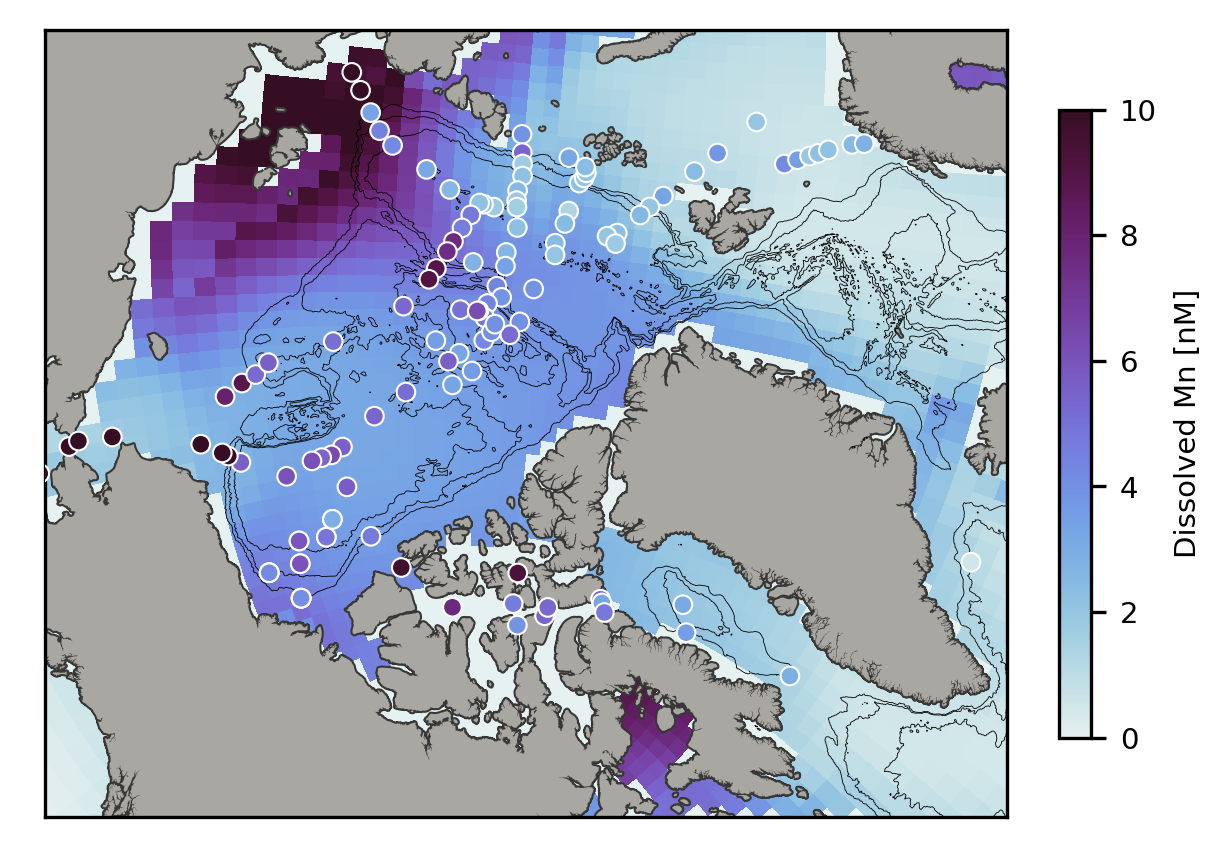

In [29]:
dmn_plot = np.mean(gbmn_dmn[0:4,:,:],axis=0)
vmax1    = 10

# ----- Plot ----------------------------
fig, ax, proj = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/AO-map-nobg.pickle','rb'))

# Plot model background field:
x_model, y_model = proj(gbmn_lon, gbmn_lat)
CS1 = proj.pcolormesh(x_model, y_model, dmn_plot[:,:], vmin=0, vmax=vmax1, cmap=cmocean.cm.dense, zorder=2)
    
# add bathymetry contours:
x, y = proj(lon, lat)
proj.contour(x, y, mesh_bathy, levels=[1000,2000,3000], linewidths=0.2, colors='k', zorder=3)
    
# Plot observations over top:
x_GTR, y_GTR = proj(GTR_lons, GTR_lats)
proj.scatter(x_GTR, y_GTR, c=GTR_dMn_PML, s=20, zorder=3, edgecolor='w', linewidth=0.5, vmin=0, vmax=vmax1, cmap=cmocean.cm.dense)

x_IPY, y_IPY = proj(IPY_lons_full, IPY_lats_full)    
proj.scatter(x_IPY, y_IPY, c=IPY_dMn_PML, s=20, zorder=3, edgecolor='w', linewidth=0.5, vmin=0, vmax=vmax1, cmap=cmocean.cm.dense)
    
proj.drawcoastlines(color='#373736', linewidth=1.0)
# Colorbar:
CBar = plt.colorbar(CS1, fraction=0.03, ticks=np.arange(0, vmax1+2, 2))
CBar.ax.tick_params(labelsize=7) 
CBar.set_label('Dissolved Mn [nM]', fontsize=7)